# 2. **makemore** (part 1): implementing a bigram character-level language model

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    print("Running in Google Colab.")
    print("Cloning repo...")
    !git clone https://github.com/ckarageorgkaneen/micrograduate.git
    %cd micrograduate
    print("Installing package...")
    !pip install --editable . --quiet

## Intro

Just like [micrograd](#1.-micrograd) before it, here, *step-by-step* with everything *spelled-out*, we will build **makemore**: a bigram character-level language model. We're going to build it out slowly and together! But what is **makemore**? As the name suggests, **makemore** *makes more* of things that you give it. [names.txt](names.txt) is an example dataset. Specifically, it is a very large list of different names. If you train **makemore** on this dataset, it will learn to *make more* of name-like things, basically more unique names! So, maybe if you have a baby and you're looking for a new, cool-sounding unique name, **makemore** might help you. Here are some examples of such names that the **makemore** will be able to generate:

```text
dontell
khylum
camatena
aeriline
najlah
sherrith
ryel
irmi
taislee
mortaz
akarli
maxfelynn
biolett
zendy
laisa
halliliana
goralynn
brodynn
romima
chiyomin
loghlyn
melichae
mahmed
irot
helicha
besdy
ebokun
lucianno
```

`dontell`, `irot`, `zendy`, and so on, you name it! So under the hood, **makemore** is a character-level language model. That means that it's treating every single line (i.e. name) of [its training dataset](names.txt) as an example. And each example is treated as a sequence of individual characters. For instance, it treats the name `reese` as the sequence of characters: `r`, `e`, `e`, `s`, `e`. That is the level on which we are building out **makemore**. Basically, its purpose is this: given a character, it can predict the next character in the sequence based upon the names that it has seen so far. Now, we're actually going to implement a large number of character-level language models, following a few key innovations:

- Bigram (one character predicts the next one with a lookup table of counts)
- MLP, following [Bengio et al. 2003](https://www.jmlr.org/papers/volume3/bengio03a/bengio03a.pdf)
- CNN, following [DeepMind WaveNet 2016](https://arxiv.org/abs/1609.03499) (in progress...)
- RNN, following [Mikolov et al. 2010](https://www.fit.vutbr.cz/research/groups/speech/publi/2010/mikolov_interspeech2010_IS100722.pdf)
- LSTM, following [Graves et al. 2014](https://arxiv.org/abs/1308.0850)
- GRU, following [Kyunghyun Cho et al. 2014](https://arxiv.org/abs/1409.1259)
- Transformer, following [Vaswani et al. 2017](https://arxiv.org/abs/1706.03762)

In fact, the transformer we are going to build will be the equivalent of [GPT-2](https://en.wikipedia.org/wiki/GPT-2). Kind of a big deal, since it's a modern network and by the end of this guide you'll actually understand how it works at the level of characters. Later on, we will probably spend some time on the word level, so we can generate documents of words, not just segments of characters. And then we're probably going to go into image and image-text networks such as [DALL-E](https://en.wikipedia.org/wiki/DALL-E), [Stable Diffusion](https://en.wikipedia.org/wiki/Stable_Diffusion), and so on. But first, let's jump into character-level modeling.

## Building a bigram language model

Let's start by reading all the names into a list:

In [2]:
words = open("names.txt").read().splitlines()

In [3]:
words[:10]

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn']

Now, we want to learn a bit more about this dataset.

In [4]:
len(words)

32033

In [5]:
len(min(words, key=len))  # shortest

2

In [6]:
len(max(words, key=len))  # longest

15

Let's think through our very first language model. A character-level language model is predicting the next character in the sequence given already some concrete sequence of characters before it. What we have to realize here is that every single word like `isabella` is actually quite a few examples packed in that single word. Because, let's think: what is a word telling us really? It's saying that the character `i` is a very likely character to come first in the sequence that constitutes a name. The character `s` is likely to come after `i`, the character `a` is likely to come after `is`, the character `b` is likely to come after `isa`, and so on all the way to `a` following `isabell`. And then there's one more important piece of information in here. And that is that after `isabella`, the word is very likely to end. So, time to build our first network: a bigram language model. In these, we are working with two characters at a time. So, we are only looking for one character we are given and we are trying to predict the next character in a sequence. For example, in the name `charlotte`, we ask: what characters are likely to follow `r`?  In the name `sophia`: we ask what characters are likely to follow `p`? And so on. This mean we are just modeling that local structure. Meaning, we only look at the previous character, even though there might be a lot of useful information before it. This is a very simple model, which is why it's a great place to start! We can learn about the statistics of which characters are likely to follow which other characters by counting. So by iterating over all names, we can count how often each consecutive pair (bigram) of characters appears.

In [7]:
b = {}
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        bigram = (ch1, ch2)
        b[bigram] = b.get(bigram, 0) + 1

Notice that we have also added the character `.` to signify the start and end of each word. And obviously, the variable `b` now holds the statistics of the entire dataset.

In [8]:
sorted(b.items(), key=lambda tup: tup[1], reverse=True)

[(('n', '.'), 6763),
 (('a', '.'), 6640),
 (('a', 'n'), 5438),
 (('.', 'a'), 4410),
 (('e', '.'), 3983),
 (('a', 'r'), 3264),
 (('e', 'l'), 3248),
 (('r', 'i'), 3033),
 (('n', 'a'), 2977),
 (('.', 'k'), 2963),
 (('l', 'e'), 2921),
 (('e', 'n'), 2675),
 (('l', 'a'), 2623),
 (('m', 'a'), 2590),
 (('.', 'm'), 2538),
 (('a', 'l'), 2528),
 (('i', '.'), 2489),
 (('l', 'i'), 2480),
 (('i', 'a'), 2445),
 (('.', 'j'), 2422),
 (('o', 'n'), 2411),
 (('h', '.'), 2409),
 (('r', 'a'), 2356),
 (('a', 'h'), 2332),
 (('h', 'a'), 2244),
 (('y', 'a'), 2143),
 (('i', 'n'), 2126),
 (('.', 's'), 2055),
 (('a', 'y'), 2050),
 (('y', '.'), 2007),
 (('e', 'r'), 1958),
 (('n', 'n'), 1906),
 (('y', 'n'), 1826),
 (('k', 'a'), 1731),
 (('n', 'i'), 1725),
 (('r', 'e'), 1697),
 (('.', 'd'), 1690),
 (('i', 'e'), 1653),
 (('a', 'i'), 1650),
 (('.', 'r'), 1639),
 (('a', 'm'), 1634),
 (('l', 'y'), 1588),
 (('.', 'l'), 1572),
 (('.', 'c'), 1542),
 (('.', 'e'), 1531),
 (('j', 'a'), 1473),
 (('r', '.'), 1377),
 (('n', 'e'),

And this is the sorted list of counts of the individual bigrams across all the words in the dataset! Now let's convert our current bigram-to-occurence-frequency map into a bigram counts array, where every row index represents the first character and every column index represents the second character of each bigram. Before doing so, we must first find a way to convert each character into a unique integer index:

In [9]:
chars = ["."] + sorted(list(set("".join(words))))
ctoi = {c: i for i, c in enumerate(chars)}
print(ctoi)

{'.': 0, 'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26}


Now that we have a character-to-index map, we may construct our bigram counts array `N`:

In [10]:
import torch

nchars = len(chars)
N = torch.zeros(nchars, nchars, dtype=torch.int32)
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        N[ctoi[ch1], ctoi[ch2]] += 1

In [11]:
N

tensor([[   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
         1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
          134,  535,  929],
        [6640,  556,  541,  470, 1042,  692,  134,  168, 2332, 1650,  175,  568,
         2528, 1634, 5438,   63,   82,   60, 3264, 1118,  687,  381,  834,  161,
          182, 2050,  435],
        [ 114,  321,   38,    1,   65,  655,    0,    0,   41,  217,    1,    0,
          103,    0,    4,  105,    0,    0,  842,    8,    2,   45,    0,    0,
            0,   83,    0],
        [  97,  815,    0,   42,    1,  551,    0,    2,  664,  271,    3,  316,
          116,    0,    0,  380,    1,   11,   76,    5,   35,   35,    0,    0,
            3,  104,    4],
        [ 516, 1303,    1,    3,  149, 1283,    5,   25,  118,  674,    9,    3,
           60,   30,   31,  378,    0,    1,  424,   29,    4,   92,   17,   23,
            0,  317,    1],
        [3983,  679,  121,  153,  384, 1271,   82,

Done! Of course, this looks like a mess. So let's visualize it better.

(-0.5, 26.5, 26.5, -0.5)

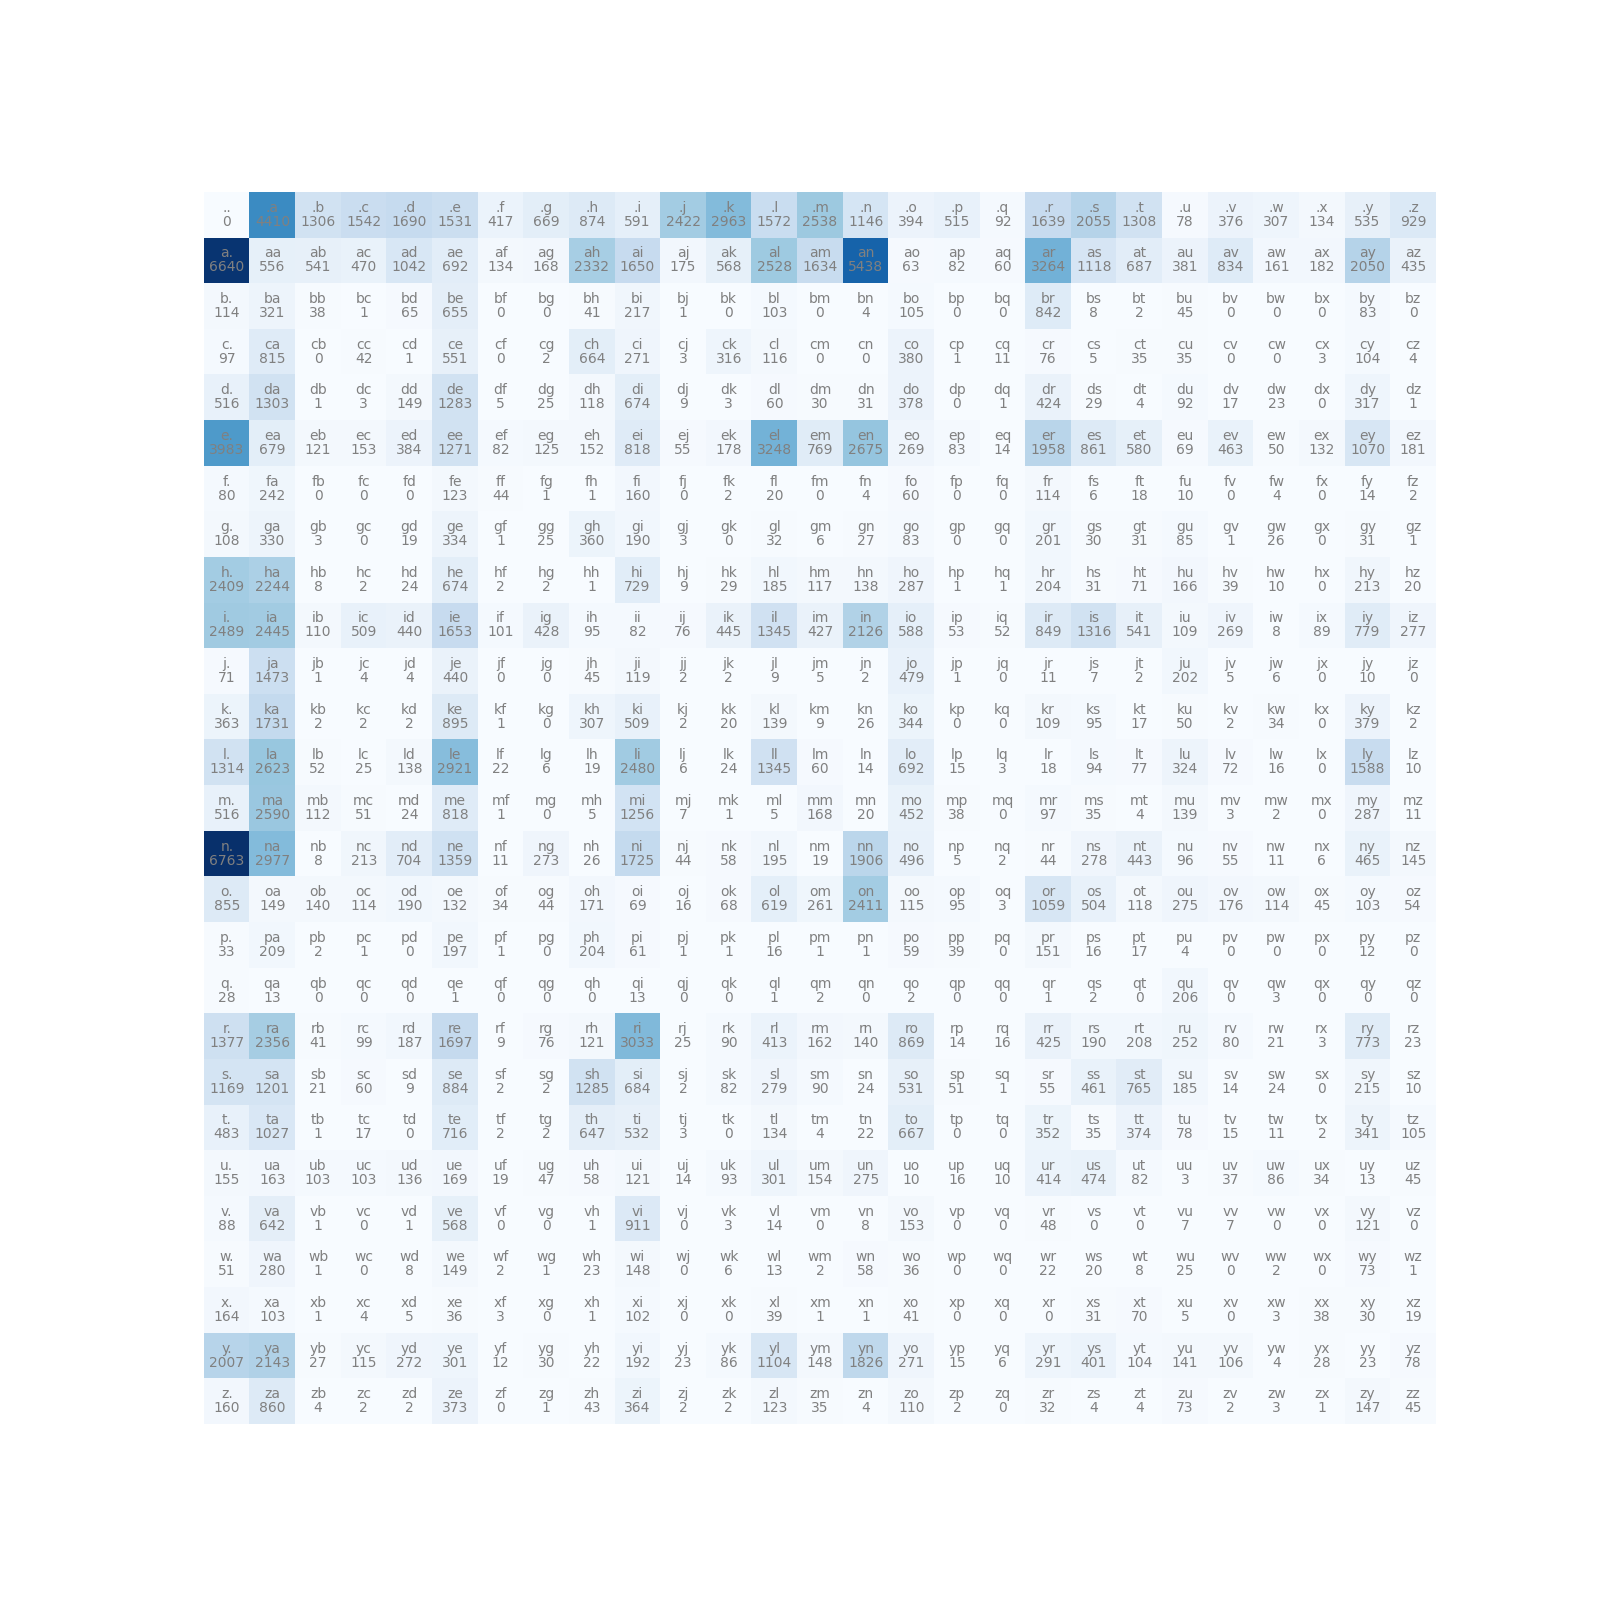

In [ ]:
import matplotlib.pyplot as plt
if IN_COLAB:
    %matplotlib inline
else:
    %matplotlib ipympl

itoc = {i: c for c, i in ctoi.items()}
plt.figure(figsize=(16, 16))
plt.imshow(N, cmap="Blues")
for i in range(27):
    for j in range(27):
        chstr = itoc[i] + itoc[j]
        plt.text(j, i, chstr, ha="center", va="bottom", color="gray")
        plt.text(j, i, N[i, j].item(), ha="center", va="top", color="gray")
plt.axis("off")

The color-graded bigram counts array! Looks good. This array actually has all the necessary information for us to start sampling from this bigram character language model. Let's just start by sampling the start character (of course) of each name: the `.` character. The first row tells us how often each other character follows it. In other words, the first row tells us how often each character is the first character of a word:

In [13]:
N[0]

tensor([   0, 4410, 1306, 1542, 1690, 1531,  417,  669,  874,  591, 2422, 2963,
        1572, 2538, 1146,  394,  515,   92, 1639, 2055, 1308,   78,  376,  307,
         134,  535,  929], dtype=torch.int32)

To get the probability of each of character being the first:

In [14]:
p = N[0].float()
p = p / p.sum()
p

tensor([0.0000, 0.1377, 0.0408, 0.0481, 0.0528, 0.0478, 0.0130, 0.0209, 0.0273,
        0.0184, 0.0756, 0.0925, 0.0491, 0.0792, 0.0358, 0.0123, 0.0161, 0.0029,
        0.0512, 0.0642, 0.0408, 0.0024, 0.0117, 0.0096, 0.0042, 0.0167, 0.0290])

Each value of this probability distribution corresponds simply to the probability of the corresponding character being the first character of a word. And of course it sums to `1`:

In [15]:
assert p.sum() == 1

Now, we'll sample numbers according to this probability distribution using [`torch.multinomial`](https://pytorch.org/docs/stable/generated/torch.multinomial.html#torch-multinomial). And to do so deterministically we are going to use a generator. So, let's take a brief detour and test out how to sample. First we create a probability distribution:

In [16]:
SEED = 2147483647
g = torch.Generator().manual_seed(SEED)
ptest = torch.rand(3, generator=g)
ptest = ptest / ptest.sum()
ptest

tensor([0.6064, 0.3033, 0.0903])

Then, we sample from this distribution:

In [17]:
s = torch.multinomial(ptest, num_samples=100, replacement=True, generator=g)
s

tensor([1, 1, 2, 0, 0, 2, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 2, 0, 0,
        1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1,
        0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 0, 0, 0, 0, 0, 1, 0, 0, 2, 0, 1, 0,
        0, 1, 1, 1])

Simple. Now, notice that it outputs the same tensor however many times you run the cells. That's because we have set a fixed seed and passed the generator object to the functions. Now, notice the output of `torch.multinomial`. What we expect is that around $60.64\%$ of the numbers to be `0`, $30.33\%$ to be `1` and $9.03\%$ to be `2`:

In [18]:
sbc = torch.bincount(s)
for i in [0, 1, 2]:
    print(f"Ratio of {i}: {sbc[i]/sbc.sum()}")

Ratio of 0: 0.6100000143051147
Ratio of 1: 0.33000001311302185
Ratio of 2: 0.05999999865889549


Not too far away from what we expected! But, if we increase the number of samples, we will get much closer to the probabilities of our distribution. Try it out! The more samples we take, the more the actual occurence ratios match the probabilities of the distribution the numbers were sampled from. Now, it's time to sample from our initial character probability distribution:

In [19]:
g = torch.Generator().manual_seed(SEED)
idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
itoc[idx]

'j'

We are now ready to write out our name generator.

In [20]:
g = torch.Generator().manual_seed(SEED)
P = N.float()
P = P / P.sum(
    1, keepdim=True
)  # sum over the column dimension and keep column dimension
for i in range(20):
    out = []
    idx = 0
    while True:
        p = P[idx]
        idx = torch.multinomial(p, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[idx])
        if idx == 0:
            break
    print("".join(out))

junide.
janasah.
p.
cony.
a.
nn.
kohin.
tolian.
juee.
ksahnaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabdinerimikimaynin.
anaasn.
ssorionsush.


It works! It yields names. Well, kinda. Some look name-like enough but most are just terrible. Lol. This is a bigrams model for you! To recap, we trained a bigrams language model essentially just by counting how frequently any pairing of characters occurs and then normalizing so that we get a nice probability distribution. Really, the elements of array `P` are the parameters of our model that summarize the statistics of these bigrams. We train the model and iteratively sample the next character and feed it in each time and get the next character. But how do we evaluate our model? We can do so, by looking at the probability of each bigram.

In [21]:
for w in words[:3]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        ix1 = ctoi[ch1]
        ix2 = ctoi[ch2]
        prob = P[ix1, ix2]
        print(f"{ch1}{ch2}: {prob:.4f}")

.e: 0.0478
em: 0.0377
mm: 0.0253
ma: 0.3899
a.: 0.1960
.o: 0.0123
ol: 0.0780
li: 0.1777
iv: 0.0152
vi: 0.3541
ia: 0.1381
a.: 0.1960
.a: 0.1377
av: 0.0246
va: 0.2495
a.: 0.1960


Here we are looking at the probabilities that the model assigns to every bigram in the dataset. Just keep in mind that we have $27$ characters, so if everything was equally likely we would expect all probabilities to be:

In [22]:
1/27

0.037037037037037035

Since they are not and we have mostly higher probabilities, it means that our model has learned something useful. In an ideal case, we would expect the bigram probabilities to be near $1.0$ (perfect prediction probability). Now, when you look at the literature of [maximum likelihood estimation](https://en.wikipedia.org/wiki/Maximum_likelihood_estimation), statistical modelling and so on, you'll see that what's typically used here is something called the likelihood: the product of all the above probabilities. This gives us the probability of the entire dataset assigned by the model that you made. But, because the product of these probabilities is an unwieldly, very tiny number to work with (think $0.0478 \times 0.0377 \times 0.0253 \times ...$), for convenience, what people usually work with is not the likelihood, but the log-likelihood. The log, as you can see:

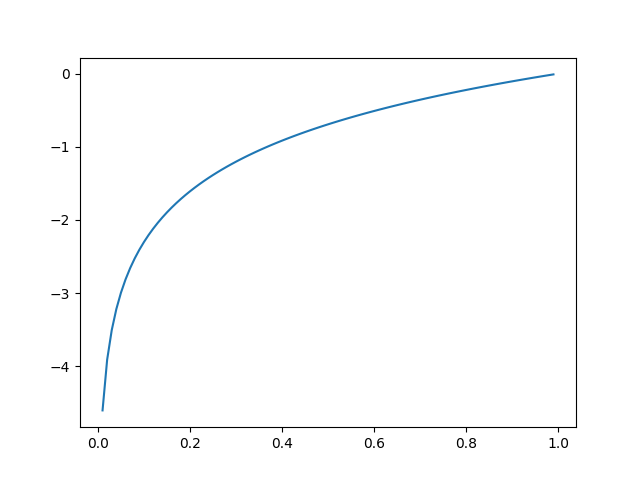

In [23]:
import numpy as np

x = np.arange(0.01, 1.0, 0.01)
y = np.log(x)
plt.figure()
plt.plot(x, y)

is a monotonic transformation of the probability, where if you pass in probability $1.0$ you get log-probability of $0$, and as the probabilities you pass in decrease, the log-probability decreases all the way to $-\infty$ as the probability approaches $0$. Therefore, let's also add the log probability in our loop to see what that looks like:

In [24]:
def test_model(iterable, print_probs=True, calc_ll=False, print_nll=False):
    if print_nll:
        calc_ll = True
    log_likelihood = 0.0
    n = 0
    for w in iterable:
        chs = ["."] + list(w) + ["."]
        for ch1, ch2 in zip(chs, chs[1:]):
            prob = P[ctoi[ch1], ctoi[ch2]]
            logprob = torch.log(prob)
            if calc_ll:
                log_likelihood += logprob.item()
                n += 1
            if print_probs:
                print(f"{ch1}{ch2}: {prob:.4f} {logprob:.4f}")
    if calc_ll:
        print(f"{log_likelihood=}")
    if print_nll:
        nll = -log_likelihood
        print(f"{nll=}")
        print(f"loss={nll/n}")
    return log_likelihood


_ = test_model(words[:3])

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299


As you can see, for higher probabilities we get closer and closer to $0$, but lower probabilities gives us a more negative number. And so to calculate the log-likelihood, we just sum up all the log probabilities:

In [25]:
log_likelihood = test_model(words[:3], calc_ll=True)

.e: 0.0478 -3.0408
em: 0.0377 -3.2793
mm: 0.0253 -3.6772
ma: 0.3899 -0.9418
a.: 0.1960 -1.6299
.o: 0.0123 -4.3982
ol: 0.0780 -2.5508
li: 0.1777 -1.7278
iv: 0.0152 -4.1867
vi: 0.3541 -1.0383
ia: 0.1381 -1.9796
a.: 0.1960 -1.6299
.a: 0.1377 -1.9829
av: 0.0246 -3.7045
va: 0.2495 -1.3882
a.: 0.1960 -1.6299
log_likelihood=-38.785636603832245


Now, how high can log-likelihood get? As high as $0$! So, when all the probabilities are $1.0$, it will be $0$. But the further away from $1.0$ they are, the more negative the log-likehood will get. Now, we don't actually like this because we are looking to define here is a **loss** function, that has the semantics where high is bad and low is good, since we are trying to minimize it. Any ideas? Well, we actually just need to invert the log-likelihood, aka take the negative log-likelihood (**nll**):

In [26]:
nll = -log_likelihood
print(f'{nll=}')

nll=38.785636603832245


**nll** is a very nice loss function because the lowest it can get is zero and the higher it is the worse off the predictions are that we are making. People also usually like to see the average of the **nll** instead of just the sum:

In [27]:
test_model(words[:3], print_probs=False, calc_ll=True, print_nll=True);

log_likelihood=-38.785636603832245
nll=38.785636603832245
loss=2.4241022877395153


Our **loss** function for the training set assigned by the model yields a **loss** of $2.424$. The lower it is, the better off we are. The higher it is, the worse off we are. So, the job of training is produce a high-quality model, by finding the parameters that minimize the **loss**. In this case, ones that minimize the **nll** **loss**. To summarize, our **goal** is to maximize likelihood of the data **w.r.t.** model parameters (in our statistical modeling case these are the bigram probabilities), which is:
- equivalent to maximizing the log-likelihood (because the $\log$ function is monotonic)
- equivalent to minimizing the **nll**
- equivalent to minimizing the average **nll**

The lower the **nll** **loss** the better, since that would mean assigning high probabilities. Remember: $\log(a \cdot b \cdot c) = \log(a) + \log(b) + \log(c)$. Also, keep in mind that here we store the probabilities in a table format. But in what's coming up, these numbers will not be kept explicitly but they will be calculated by a **nn** and we will change its parameters to maximize the likelihood of these probabilities. Let's now test out our model with a random name:

In [28]:
test_model(iterable=['christosqj'], calc_ll=True, print_nll=True);

.c: 0.0481 -3.0337
ch: 0.1880 -1.6713
hr: 0.0268 -3.6199
ri: 0.2388 -1.4320
is: 0.0743 -2.5990
st: 0.0944 -2.3605
to: 0.1197 -2.1224
os: 0.0635 -2.7563
sq: 0.0001 -9.0004
qj: 0.0000 -inf
j.: 0.0245 -3.7098
log_likelihood=-inf
nll=inf
loss=inf


As you can see, the probability of the bigram `sq` is super low. Whereas the probability for `qj`, since it is never encountered in our training data (see our bigram count table!), is $0$, which predictably yields a log-probability of $-\infty$, which in turn causes the **loss** to be $-\infty$. What this means is that this model is exactly $0 \%$ likely to predict this name (infinite **loss**). If you look up the table you see that `q` is followed by `j` zero times. This kind of behavior people don't usually like too much, so there is a simple trick to alleviate it: model smoothing. It involves adding some fake counts to the bigram counts array so that never is there a bigram with `0` counts (and therefore `0` probability). This ensures that there are no zeros in our bigram counts matrix. E.g.

In [29]:
P = (N + 1).float()
P = P / P.sum(
    1, keepdim=True
)  # sum over the column dimension and keep column dimension
test_model(iterable=["christosqj"], calc_ll=True, print_nll=True)

.c: 0.0481 -3.0339
ch: 0.1869 -1.6774
hr: 0.0268 -3.6185
ri: 0.2384 -1.4338
is: 0.0743 -2.5998
st: 0.0942 -2.3625
to: 0.1193 -2.1257
os: 0.0634 -2.7578
sq: 0.0002 -8.3105
qj: 0.0033 -5.7004
j.: 0.0246 -3.7051
log_likelihood=-37.32549834251404
nll=37.32549834251404
loss=3.393227122046731


-37.32549834251404

Now, we avoid getting a loss of $-\infty$. Cool! So we've now trained a respectable bigram character-level language model. We trained the model by looking at the counts of all the bigrams and normalizing the rows to get probability distributions. We saw that we can also then use those parameters of this model to perform sampling of new words (sample new names according to these distributions) and evaluate the quality of this model which is summarized by a single number: the **nll**. And the lower this number is, the better the model is because it is giving high probabilities to the actual mixed characters of all the bigrams in our training set. Great! We basically, counted and then normalized those counts, which is sensible enough.

## Casting the model as a **nn**

Let's now try a different approach by casting such a bigram language model into a **nn** framework to achieve the same goal. Our **nn** is still going to be a bigram character-level language model. It will receive a single character as an input that will pass through a bunch of weighted neurons and then output the probability distribution over the next character in the sequence. It's going to make guesses about what character is going to follow the input character. In addition, we'll be able to evaluate any setting of the parameters of the **nn**, since we have a **loss** function. Basically, we're going to take a look at the probabilities distributions our model assigns for our next character and find the **loss** between those and the labels (which are the character that we expect to come next in the bigram). By doing so, we can use gradient-based optimization to tune the weights of our **nn** that give us the output probabilities. Let's begin this alternative approach by first constructing our dataset:

In [30]:
# Create training dataset of bigrams (x, y)
xs, ys = [], []
for w in words[:1]:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        print(ch1, ch2)
        xs.append(ctoi[ch1])
        ys.append(ctoi[ch2])
# Convert to pytorch tensor (https://pytorch.org/docs/stable/generated/torch.tensor.html)
xs = torch.tensor(xs)
ys = torch.tensor(ys)

. e
e m
m m
m a
a .


In [31]:
xs

tensor([ 0,  5, 13, 13,  1])

In [32]:
ys

tensor([ 5, 13, 13,  1,  0])

Now, how do we pass each character into the **nn**? [One-hot encoding](https://en.wikipedia.org/wiki/One-hot)! With this encoding, each integer is encoded with bits.

In [33]:
import torch.nn.functional as F

xenc = F.one_hot(xs, num_classes=27).float()
xenc

tensor([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0.]])

In [34]:
xenc.shape

torch.Size([5, 27])

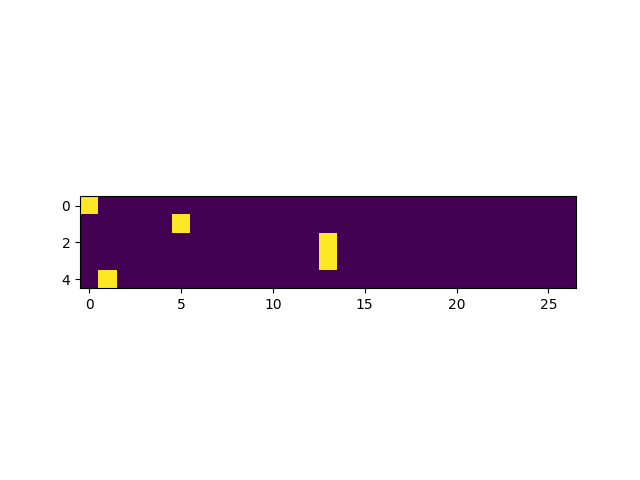

In [35]:
plt.figure()
plt.imshow(xenc);

Let's create our neuron:

In [36]:
W = torch.randn((27, 1))
xenc @ W

tensor([[-0.9738],
        [-1.6029],
        [-0.8176],
        [-0.8176],
        [ 1.1141]])

Our neuron receives one character of size $27$ and spits out $1$ output value. However, as you can see, since PyTorch supports matrix multiplication, our neuron can receive $5$ characters of size $27$ in parallel and output each character's output in a $5 \times 1$ matrix ($[5 \times 27] \cdot [27 \times 1] \rightarrow [5 \times 1]$). Now, let's pass our $5$ characters as inputs through $27$ neurons instead of just $1$ neuron:

In [37]:
W = torch.randn((27, 27))
xenc @ W

tensor([[-0.5210, -1.7075,  0.0606, -0.4760, -0.6978, -0.6031, -0.9938, -0.1152,
         -1.4559,  0.0559, -1.3989,  0.3653, -1.8183,  0.1946, -0.4269,  0.0731,
          0.2234,  1.0969,  1.6320,  1.4863, -2.4014,  0.2011,  1.4461, -1.0095,
         -0.4779,  0.2841,  1.3783],
        [-1.4349,  0.4780,  1.4498, -0.6760,  0.0286, -0.9714, -1.2334,  0.3454,
         -0.1060, -0.7918, -0.8194,  0.5075, -1.0525,  0.0992,  0.8406, -0.2120,
         -1.2580, -0.3917, -0.4343, -0.4624,  0.2379,  1.0808,  0.9822, -0.2952,
          0.5719, -0.6113, -1.4737],
        [ 0.0355,  0.9803,  1.7415, -0.0843,  0.6643, -1.4008, -1.5444, -2.5435,
         -0.8498,  0.4378,  0.8168,  1.1876, -0.7164,  1.2997,  2.0408, -3.1324,
          0.4019, -1.9673,  0.4383, -0.4259, -0.8767,  0.9151,  0.6122, -0.0254,
          0.6593,  1.8603, -0.5538],
        [ 0.0355,  0.9803,  1.7415, -0.0843,  0.6643, -1.4008, -1.5444, -2.5435,
         -0.8498,  0.4378,  0.8168,  1.1876, -0.7164,  1.2997,  2.0408, -3.1324

Predictably, we get $5$ arrays (one per input/character) of $27$ outputs ($[5 \times 27] \cdot [27 \times 27] \rightarrow [5 \times 27]$). Each output number represents each neuron's firing rate of a specific input. For example, the following is the firing rate of the 13th neuron of the 3rd input:

In [38]:
(xenc @ W)[3, 13]

tensor(1.2997)

What PyTorch allows is matrix multiplication that enables parallel dot products of many inputs in a batch with the weights of neurons of a **nn**. For example, this is how to multiply the inputs that represent the 3rd character with the weights of the 13th neuron:

In [39]:
xenc[3]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [40]:
W[:, 13]

tensor([ 0.1946,  0.4877,  0.5619,  1.0226,  0.9183,  0.0992, -0.0055,  0.4631,
        -0.8496,  0.0252, -1.3195,  0.3918,  0.9681,  1.2997,  0.4193, -0.6578,
        -0.7592, -0.5332, -0.3384, -0.8118,  0.3298,  0.3787,  1.2501, -0.0395,
        -0.7877, -0.6238, -0.1939])

In [41]:
(xenc[3] * W[:, 13]).sum()

tensor(1.2997)

In [42]:
(xenc @ W)[3, 13]  # same as above

tensor(1.2997)

Ok, so what did is we fed our $27$-dimensional inputs into the first layer of a **nn** that has 27 neurons. These neurons perform `W * x`. They don't have a bias and they don't have a non-linearity like `tanh`. We are going to leave our network as is: a 1-layer _linear_ **nn**. That's it. Basically, the dumbest, smallest, simplest **nn**. Remember, what we trying to produce is a probability distribution for a next character in a sequence. And there's $27$ of them. But we have to come up with exact semantics as to how we are going to interpret these $27$ numbers that these neurons take on. Intuitively, as we can see in the `xenc @ W` output, some of these outputs numbers are positive and some negative. That's because they come out of a **nn** layer with weights are initialized from the normal $[-1, 1]$ distribution. But, what we want however is something like a bigram count table that we previously produced, where each row told us the counts which we then normalized to get the probabilities. So, we want something similar to come out of our **nn**. But, what we have right now, are some negative and positive numbers. Now, we therefore want these numbers to represent the probabilities for the next character with their unique characteristics. For example, probabilities are positive numbers and they sum to 1. Also, they obviously have to be probabilities. They can't be counts because counts are positive integers; not a great output from a **nn**. Instead, what the **nn** is going to output and how we are going to interpret these $27$ output numbers is as log counts. One way to accomplish this is by exponentiating each output number so that the result is always positive. Specifically, exponentiating a  negative number yields a result that is a positive value *less* than $1$. Whereas, exponentiating a positive number yields a result whose value is between greater than $1$ and $\infty$.

In [43]:
(xenc @ W).exp()

tensor([[ 0.5940,  0.1813,  1.0624,  0.6213,  0.4977,  0.5471,  0.3702,  0.8912,
          0.2332,  1.0575,  0.2469,  1.4409,  0.1623,  1.2148,  0.6525,  1.0758,
          1.2504,  2.9948,  5.1142,  4.4209,  0.0906,  1.2228,  4.2465,  0.3644,
          0.6201,  1.3285,  3.9681],
        [ 0.2381,  1.6129,  4.2622,  0.5087,  1.0290,  0.3786,  0.2913,  1.4126,
          0.8994,  0.4530,  0.4407,  1.6612,  0.3491,  1.1043,  2.3177,  0.8089,
          0.2842,  0.6759,  0.6477,  0.6298,  1.2685,  2.9471,  2.6704,  0.7444,
          1.7716,  0.5427,  0.2291],
        [ 1.0362,  2.6653,  5.7059,  0.9191,  1.9432,  0.2464,  0.2134,  0.0786,
          0.4275,  1.5492,  2.2632,  3.2793,  0.4885,  3.6681,  7.6970,  0.0436,
          1.4947,  0.1398,  1.5500,  0.6532,  0.4162,  2.4970,  1.8445,  0.9749,
          1.9334,  6.4256,  0.5748],
        [ 1.0362,  2.6653,  5.7059,  0.9191,  1.9432,  0.2464,  0.2134,  0.0786,
          0.4275,  1.5492,  2.2632,  3.2793,  0.4885,  3.6681,  7.6970,  0.0436

Such exponentiation is a great way to make the **nn** predict counts. Which are positive numbers that can take on various values depending on the setting of `W`. Let's break it down more:

In [44]:
logits = xenc @ W  # log-counts
counts = logits.exp()  # equivalent to the N bigram counts array
probs = counts / counts.sum(1, keepdims=True)
probs

tensor([[0.0163, 0.0050, 0.0291, 0.0170, 0.0136, 0.0150, 0.0101, 0.0244, 0.0064,
         0.0290, 0.0068, 0.0395, 0.0045, 0.0333, 0.0179, 0.0295, 0.0343, 0.0821,
         0.1402, 0.1212, 0.0025, 0.0335, 0.1164, 0.0100, 0.0170, 0.0364, 0.1088],
        [0.0079, 0.0534, 0.1412, 0.0169, 0.0341, 0.0125, 0.0097, 0.0468, 0.0298,
         0.0150, 0.0146, 0.0550, 0.0116, 0.0366, 0.0768, 0.0268, 0.0094, 0.0224,
         0.0215, 0.0209, 0.0420, 0.0977, 0.0885, 0.0247, 0.0587, 0.0180, 0.0076],
        [0.0204, 0.0525, 0.1125, 0.0181, 0.0383, 0.0049, 0.0042, 0.0015, 0.0084,
         0.0305, 0.0446, 0.0646, 0.0096, 0.0723, 0.1517, 0.0009, 0.0295, 0.0028,
         0.0306, 0.0129, 0.0082, 0.0492, 0.0364, 0.0192, 0.0381, 0.1267, 0.0113],
        [0.0204, 0.0525, 0.1125, 0.0181, 0.0383, 0.0049, 0.0042, 0.0015, 0.0084,
         0.0305, 0.0446, 0.0646, 0.0096, 0.0723, 0.1517, 0.0009, 0.0295, 0.0028,
         0.0306, 0.0129, 0.0082, 0.0492, 0.0364, 0.0192, 0.0381, 0.1267, 0.0113],
        [0.0190, 0.0159,

Therefore, we have a way to get the probabilities, where each row sums to $1$ (since they are normalized), e.g.

In [45]:
probs[0].sum().item()

0.9999998807907104

In [46]:
probs.shape

torch.Size([5, 27])

What we have achieved is that for every one of our $5$ examples, we now have a row that came out of our **nn**. And because of the transformations here, we made sure that this output of the **nn** can be interpreted as probabilities. In other words, what we have done is that we took inputs, applied differentiable operations on them (e.g. `@`, `exp()`) that we can **backprop** through and we are getting out probability distributions. Take the first input character that was fed in as an example:

In [47]:
xenc[0]

tensor([1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 0., 0.])

that corresponds to the `.` symbol from the name:

In [48]:
words[0]

'emma'

The way we fed this character into the neural network is that we first got its index, then we one-hot encoded it, then it went into the **nn** and out came this distribution of probabilities:

In [49]:
probs[0]

tensor([0.0163, 0.0050, 0.0291, 0.0170, 0.0136, 0.0150, 0.0101, 0.0244, 0.0064,
        0.0290, 0.0068, 0.0395, 0.0045, 0.0333, 0.0179, 0.0295, 0.0343, 0.0821,
        0.1402, 0.1212, 0.0025, 0.0335, 0.1164, 0.0100, 0.0170, 0.0364, 0.1088])

with a shape of:

In [50]:
probs[0].shape

torch.Size([27])

$27$ numbers. We interpret these numbers of `probs[0]` as the probability or _how likely it is_ for each of the corresponding characters to come next. As we train the **nn** by tuning the weights `W`, we are of course going to be getting different probabilities out for every character that you input. So, the question is: can we tune `W` such that the probabilities coming out are *pretty good*? The way we measure *pretty good* is by the **loss** function. Below you can see what have done in a simple summary:

In [51]:
# SUMMARY ------------------------------>>>>
xs  # inputs

tensor([ 0,  5, 13, 13,  1])

In [52]:
ys  # targets

tensor([ 5, 13, 13,  1,  0])

Both `xs` and `ys` constitute the dataset. They are integers representing characters of a sequence/word.

In [53]:
# Use a generator for reproducability and randomly initialize 27 neurons' weights. Each neuron receives 27 inputs.
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g)  # 27 incoming weights for 27 neurons
# Encode the inputs into one-hot representations
xenc = F.one_hot(xs, num_classes=27).float()  # input to the network: one-hot encoding
# Pass encoded inputs through first layer to get logits
logits = xenc @ W  # predict log-counts
# Exponentiate the logits to get fake counts
counts = logits.exp()  # counts, equivalent to N
# Normalize these counts to get probabilities
probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
# NOTE: the 2 lines above constitute what is called a 'softmax'
probs.shape

torch.Size([5, 27])

Softmax is a very-often-used **loss** function in **nn**s. It takes in logits, exponentiates them, then divides and normalizes. It's a way of taking outputs of a linear layer that might be positive or negative and it outputs numbers that are only positive and always sum to $1$, adhering to the properties of probability distributions. It can be viewed as a normalization function if you want to think of it that way.

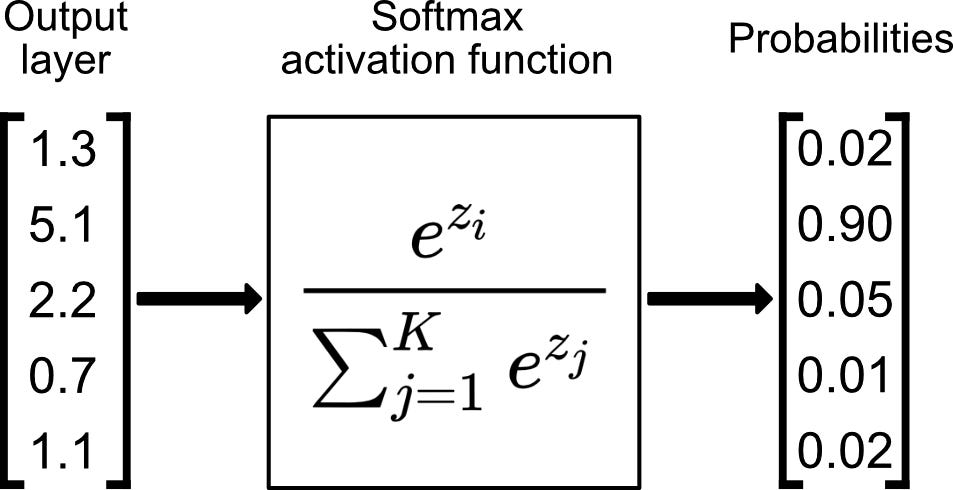

In [54]:
from IPython.display import Image, display
display(Image(filename='softmax.jpeg'))

Now, since every operation in the forward pass is differentiable, we can **backprop** through. Below, we iterate over every input character and describe what is going on:

In [55]:
nlls = torch.zeros(5)
for i in range(5):
    # i-th bigram:
    x = xs[i].item()  # input character index
    y = ys[i].item()  # label character index
    print("--------")
    print(f"bigram example {i+1}: {itoc[x]}{itoc[y]} (indexes {x},{y})")
    print("input to the nn:", x)
    print("output probabilities from the nn:", probs[i])
    print("label (actual next character):", y)
    p = probs[i, y]
    print("probability assigned by the nn to the correct next character:", p.item())
    logp = torch.log(p)
    print("log likelihood:", logp.item())
    nll = -logp
    print("negative log likelihood:", nll.item())
    nlls[i] = nll
loss = nlls.mean()
print("=========")
print("average negative log likelihood, i.e. loss =", loss.item())

--------
bigram example 1: .e (indexes 0,5)
input to the nn: 0
output probabilities from the nn: tensor([0.0607, 0.0100, 0.0123, 0.0042, 0.0168, 0.0123, 0.0027, 0.0232, 0.0137,
        0.0313, 0.0079, 0.0278, 0.0091, 0.0082, 0.0500, 0.2378, 0.0603, 0.0025,
        0.0249, 0.0055, 0.0339, 0.0109, 0.0029, 0.0198, 0.0118, 0.1537, 0.1459])
label (actual next character): 5
probability assigned by the nn to the correct next character: 0.01228625513613224
log likelihood: -4.399273872375488
negative log likelihood: 4.399273872375488
--------
bigram example 2: em (indexes 5,13)
input to the nn: 5
output probabilities from the nn: tensor([0.0290, 0.0796, 0.0248, 0.0521, 0.1989, 0.0289, 0.0094, 0.0335, 0.0097,
        0.0301, 0.0702, 0.0228, 0.0115, 0.0181, 0.0108, 0.0315, 0.0291, 0.0045,
        0.0916, 0.0215, 0.0486, 0.0300, 0.0501, 0.0027, 0.0118, 0.0022, 0.0472])
label (actual next character): 13
probability assigned by the nn to the correct next character: 0.018050700426101685
log likelihoo

As you can see, the probabilities assigned by the **nn** to the correct next character are bad (pretty low). See for example the probability predicted by the network of `m` following `e` (`em` example): the **nll** value is very high (e.g. $4.0145$). And in general, for the whole word, the **loss** (the average **nll**) is high! This means that this is not a favorable setting of weights and we can do better. One easy way to do better is to reinitialize `W` using a different seed for example and pray to god that the loss is smaller or repeat until it is. But that is what amateurs do. We are professionals or, at least, we want to be! And what professionals do is they start with random weights, like we did, and then they optimize those weights in order to minimize the loss. We do so by some gradient-based optimization (e.g. gradient descent) which entails first doing backprop in order to compute the gradients of that weight **w.r.t.** to those weights and then changing the weights by some such gradient amount in order to optimize them and minimize the loss. As we did with **micrograd**, we will write an optimization loop for doing the backward pass. But instead of mean-squared error, we are using the **nll** as a loss function, since we are dealing with a classification task and not a regression one.

In [56]:
g = torch.Generator().manual_seed(SEED)
W = torch.randn(
    (27, 27), generator=g, requires_grad=True
)  # 27 incoming weights for 27 neurons


def forward_pass(regularize=False):
    num = xs.nelement()
    xenc = F.one_hot(
        xs, num_classes=27
    ).float()  # input to the network: one-hot encoding
    logits = xenc @ W  # predict log-counts
    counts = logits.exp()  # counts, equivalent to N
    probs = counts / counts.sum(1, keepdims=True)  # probabilities for next character
    loss = -probs[torch.arange(num), ys].log().mean()
    return W, loss


W, loss = forward_pass()
# backward pass
W.grad = None  # set to zero
loss.backward()

Now, something magical happened when `backward` ran. Like **micrograd**, PyTorch, during the forward pass, keeps track of all the operations under the hood and builds a full computational graph. So, it knows all the dependencies and all the mathematical operations of everything. Therefore, calling `backward` on the **loss** fills in the gradients of all the intermediate nodes, all the way back to the `W` value nodes. Take a look:

In [57]:
W.grad

tensor([[ 0.0121,  0.0020,  0.0025,  0.0008,  0.0034, -0.1975,  0.0005,  0.0046,
          0.0027,  0.0063,  0.0016,  0.0056,  0.0018,  0.0016,  0.0100,  0.0476,
          0.0121,  0.0005,  0.0050,  0.0011,  0.0068,  0.0022,  0.0006,  0.0040,
          0.0024,  0.0307,  0.0292],
        [-0.1970,  0.0017,  0.0079,  0.0020,  0.0121,  0.0062,  0.0217,  0.0026,
          0.0025,  0.0010,  0.0205,  0.0017,  0.0198,  0.0022,  0.0046,  0.0041,
          0.0082,  0.0016,  0.0180,  0.0106,  0.0093,  0.0062,  0.0010,  0.0066,
          0.0131,  0.0101,  0.0018],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
          0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000

And obviously:

In [58]:
assert W.shape == W.grad.shape

What a gradient value is telling us, e.g.

In [59]:
W.grad[1][4].item()

0.012119228951632977

is that nudging the specific corresponding weight by a small `h` value, would nudge the **loss** by that gradient amount. Since we want to decrease the **loss**, we simply need to change the weights by a small negative fraction of the gradients in order to move them in the direction that locally most steeply decreases the **loss** value:

In [60]:
W.data += -0.1 * W.grad

We just did a single gradient descent optimization step, which means that if we re-calculate the loss, it will be lower:

In [61]:
W, loss = forward_pass()
loss.item()

3.7492127418518066

Tada! All we have to do now is put everything together and stick the single step into a loop so that we can do multi-step gradient descent optimization. This time, for all the words in our dataset, not just `emma`!

In [62]:
# create the dataset
xs, ys = [], []
for w in words:
    chs = ["."] + list(w) + ["."]
    for ch1, ch2 in zip(chs, chs[1:]):
        xs.append(ctoi[ch1])
        ys.append(ctoi[ch2])
xs = torch.tensor(xs)
ys = torch.tensor(ys)
num = xs.nelement()
print("number of examples (bigrams): ", num)
# initialize the 'network'
g = torch.Generator().manual_seed(SEED)
W = torch.randn((27, 27), generator=g, requires_grad=True)

number of examples (bigrams):  228146


In [63]:
# gradient descent
for k in range(100):
    W, loss = forward_pass()
    print(loss.item())
    # backward pass
    W.grad = None  # set to zero the gradient
    loss.backward()
    # update
    W.data += -50 * W.grad

3.758953809738159
3.371098756790161
3.1540417671203613
3.020373821258545
2.9277119636535645
2.860402822494507
2.8097293376922607
2.7701027393341064
2.7380733489990234
2.711496591567993
2.6890034675598145
2.6696884632110596
2.6529300212860107
2.638277292251587
2.6253881454467773
2.6139907836914062
2.603863477706909
2.5948219299316406
2.586712121963501
2.57940411567688
2.572789192199707
2.5667762756347656
2.5612881183624268
2.5562589168548584
2.551633596420288
2.547365665435791
2.5434155464172363
2.539748430252075
2.5363364219665527
2.5331544876098633
2.5301806926727295
2.5273969173431396
2.5247862339019775
2.522334575653076
2.520029067993164
2.517857789993286
2.515810966491699
2.513878345489502
2.512052059173584
2.510324001312256
2.5086867809295654
2.5071346759796143
2.5056610107421875
2.5042612552642822
2.502929210662842
2.5016613006591797
2.5004522800445557
2.4992990493774414
2.498197317123413
2.497144937515259
2.496137857437134
2.495173692703247
2.4942495822906494
2.493363380432129
2

Awesome! What we least expect is that our **loss**, by using such gradient-based optimization, becomes as small as the **loss** we got by our more primitive bigram-count-matrix way that we previously employed for optimizing. So, basically, before, we achieved roughly the same **loss** just by counting, whereas now we used gradient descent. It just happens that the explicit, counting approach nicely optimizes the model without the need for any gradient-based optimization because the setup for bigram language models is so straightforward and simple that we can afford to just directly estimate the probabilities and keep them in a table. However, the **nn** approach is much more flexible and scalable! And we have actually gained a lot. What we can do from hereon is expand and complexify our approach. Meaning, that instead of just taking a single character and predicting the next one in an extremely simple **nn**, as we have done so far, we will be taking multiple previous characters and we will be feeding them into increasingly more complex **nn**s. But, fundamentally, we will still be just calculating logits that will be going through exactly the same transformation by passing them through a softmax and doing the same gradient-based optimization process we just did. But before we do that, remember the smoothing we did by adding fake counts to our bigram count matrix? Turns out, we can do equivalent smoothing in our **nn** too! In particular, just incentivizing the weights to be zero for example leads to the probabilities being uniform, which is a form of smoothing. Such incentivization can be accomplished through regularization. It involves just adding a term like this:

In [64]:
(W**2).mean()

tensor(1.6880, grad_fn=<MeanBackward0>)

to the **loss** as such:

```python
loss = -probs[torch.arange(num), ys].log().mean() + 0.01 * (W**2).mean()
```

where `0.01` represents the strength of the regulatization term. Optimizing with this term included in the loss would smoothen the model. Yay! Lastly, let's sample from our **nn**:

In [65]:
g = torch.Generator().manual_seed(SEED)
for i in range(20):
    out = []
    ix = 0
    while True:
        xenc = F.one_hot(torch.tensor([ix]), num_classes=27).float()
        logits = xenc @ W  # predict log-counts
        counts = logits.exp()  # counts, equivalent to N
        probs = counts / counts.sum(1, keepdims=True) # probabilities for next character
        # sample from probabilities distribution
        ix = torch.multinomial(probs, num_samples=1, replacement=True, generator=g).item()
        out.append(itoc[ix])
        if ix == 0:
            break
    print(''.join(out))

junide.
janasah.
p.
cfay.
a.
nn.
kohin.
tolian.
juwe.
kilanaauranilevias.
dedainrwieta.
ssonielylarte.
faveumerifontume.
phynslenaruani.
core.
yaenon.
ka.
jabi.
werimikimaynin.
anaasn.


We are getting kind of the same results as we previously did with our counting method! Not unpredictable at all, since our **loss** values are close enough. If we trained our **nn** more and the **loss** values became the same, it would means that the two models are identical. Meaning that given the same inputs, they would spit out the same outputs.

## Summary

All in all, we have actually covered lots of ground. To sum up, we introduced the bigram character language model, we saw how we can train the model, how we can sample from the model and how we can evaluate the quality of the model using the **nll** **loss**. We actually trained the model in two completely different ways that actually give or can give (with adequate training) the same result. In the first way, we just counted up the frequency of all the bigrams and normalized. Whereas, in the second way, we used the **nll** **loss** as a guide to optimizing the counts matrix or the counts array, so that the **loss** is minimized in a gradient-based framework. Despite our **nn** being super simple (single linear layer), it is the more flexible approach.

## Outro

In the follow-up lessons, we are going to complexify by taking more and more of these characters and we are going to be feeding them into a new **nn** that does more exciting stuff. Buckle up!